In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from collections import Counter

# Votações de cada parlamentar

In [ ]:
years = [2019, 2020, 2021, 2022]

total = 0

for year in years:

    df = pd.read_csv(f"votacoesVotos\\votacoesVotos-{year}.csv", sep=";")
    num_unique = df["idVotacao"].nunique()

    total += num_unique

    print(f"[{year}] Número de diferentes idVotacao: {num_unique}")

print(f"Número total de diferentes idVotacao: {total}")


[2019] Número de diferentes idVotacao: 333


[2020] Número de diferentes idVotacao: 393
[2021] Número de diferentes idVotacao: 958
[2022] Número de diferentes idVotacao: 586
Número total de diferentes idVotacao: 2270


# Histograma de proposições

In [ ]:
# Lista de anos
anos = [2019, 2020, 2021, 2022]

# Dicionário para armazenar todas as contagens de cada idVotacao
contagens = Counter()

for ano in anos:
    df = pd.read_csv(f"votacoesVotos/votacoesVotos-{ano}.csv", sep=";")
    
    # Conta quantas vezes cada idVotacao aparece nesse ano
    freq = df["idVotacao"].value_counts()
    
    # Atualiza o contador global
    contagens.update(freq.to_dict())


In [41]:
# Listas separadas
acima_250 = [id_v for id_v, count in contagens.items() if count >= 250]
abaixo_ou_igual_250 = [id_v for id_v, count in contagens.items() if count < 250]

# Escreve em arquivos TXT
with open("idVotacao_acima_250.txt", "w") as f:
    for id_v in acima_250:
        f.write(f"{id_v}\n")

with open("idVotacao_abaixo_ou_igual_250.txt", "w") as f:
    for id_v in abaixo_ou_igual_250:
        f.write(f"{id_v}\n")

print(f"Salvo {len(acima_250)} idVotacao em 'idVotacao_acima_250.txt'")
print(f"Salvo {len(abaixo_ou_igual_250)} idVotacao em 'idVotacao_abaixo_ou_igual_250.txt'")


Salvo 1971 idVotacao em 'idVotacao_acima_250.txt'
Salvo 299 idVotacao em 'idVotacao_abaixo_ou_igual_250.txt'


In [ ]:
# Cria um histograma: eixo X = valores de repetição, eixo Y = quantos idVotacao têm esse valor
valores_repetidos = list(contagens.values())

plt.figure(figsize=(20, 12))  # figura bem grande

plt.hist(valores_repetidos,
         bins=range(1, max(valores_repetidos)+2),
         align="left",
         edgecolor="black")

plt.xlabel("Quantidade de votos para as proposições", fontsize=18)
plt.ylabel("Quantidade de proposições com esse número de votos", fontsize=18)
plt.title("Distribuição de votos por proposição", fontsize=20)

# Definir ticks no eixo X de 10 em 10
plt.xticks(range(0, max(valores_repetidos)+1, 10), fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Salva em PDF
plt.savefig("histograma_idVotacao.pdf", format="pdf")

plt.close()


# Deputados

In [ ]:
# Lista de anos
anos = [2019, 2020, 2021, 2022]

# Dicionário para armazenar todas as contagens_dep de cada idVotacao
contagens_dep = Counter()

for ano in anos:
    df = pd.read_csv(f"votacoesVotos/votacoesVotos-{ano}.csv", sep=";")
    
    # Conta quantas vezes cada idVotacao aparece nesse ano
    freq = df["deputado_id"].value_counts()
    
    # Atualiza o contador global
    contagens_dep.update(freq.to_dict())


In [31]:
print(len(list(contagens_dep.keys())))

597


# Desenhar Grafo

In [ ]:
# === 2️⃣ CARREGAR E CONCATENAR OS DADOS ===
arquivos = [
    "votacoesVotos/votacoesVotos-2019.csv",
    "votacoesVotos/votacoesVotos-2020.csv",
    "votacoesVotos/votacoesVotos-2021.csv",
    "votacoesVotos/votacoesVotos-2022.csv"
]

dfs = []
for arquivo in arquivos:
    df = pd.read_csv(arquivo, sep=';', quotechar='"')
    dfs.append(df)

dados = pd.concat(dfs, ignore_index=True)

# Filtra apenas as votações com mais de 250 votos
dados = dados[dados["idVotacao"].isin(acima_250)]

# Normaliza os votos
dados["voto"] = dados["voto"].astype(str).str.strip().str.lower()

# === 3️⃣ CATEGORIZA O VOTO ===
def classificar_voto(v):
    if v == "sim":
        return "sim"
    elif v in ["não", "nao"]:
        return "não"
    else:
        return "outro"

dados["categoria_voto"] = dados["voto"].apply(classificar_voto)

# === 4️⃣ CRIA O GRAFO COMPLETO ===
G = nx.Graph()

for _, row in dados.iterrows():
    votacao_node = f"votacao_{row['idVotacao']}"
    deputado_node = f"deputado_{row['deputado_id']}"
    voto_valor = row["categoria_voto"]
    
    # Adiciona nós com atributos
    G.add_node(votacao_node, tipo="votacao")
    G.add_node(
        deputado_node,
        tipo="deputado",
        nome=row["deputado_nome"],
        partido=row["deputado_siglaPartido"],
        uf=row["deputado_siglaUf"]
    )
    
    # Adiciona a aresta com o tipo de voto
    G.add_edge(votacao_node, deputado_node, voto=voto_valor)

# === 5️⃣ SALVA O GRAFO ===
nx.write_graphml(G, "votacoes_completas_acima_250.graphml")

print(f"Grafo completo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")
print("Arquivo salvo como 'votacoes_completas_acima_250.graphml'.")

Grafo bipartite colorido criado com 2568 nós e 790525 arestas.
Arquivo salvo como 'votacoes_bipartite_colorida_acima_250.graphml'.


In [ ]:
# === 1️⃣ CONTAGEM DE VOTOS POR idVotacao ===
anos = [2019, 2020, 2021, 2022]
contagens = Counter()

for ano in anos:
    df = pd.read_csv(f"votacoesVotos/votacoesVotos-{ano}.csv", sep=";")
    freq = df["idVotacao"].value_counts()
    contagens.update(freq.to_dict())

# Filtra votações com mais de 250 votos
acima_250 = [id_v for id_v, count in contagens.items() if count >= 250]
print(f"{len(acima_250)} votações com mais de 250 votos identificadas.")

# === 2️⃣ CARREGAR E CONCATENAR OS DADOS ===
arquivos = [
    "votacoesVotos/votacoesVotos-2019.csv",
    "votacoesVotos/votacoesVotos-2020.csv",
    "votacoesVotos/votacoesVotos-2021.csv",
    "votacoesVotos/votacoesVotos-2022.csv"
]

dfs = [pd.read_csv(arquivo, sep=';', quotechar='"') for arquivo in arquivos]
dados = pd.concat(dfs, ignore_index=True)
dados = dados[dados["idVotacao"].isin(acima_250)]
dados["voto"] = dados["voto"].astype(str).str.strip().str.lower()

# === 3️⃣ CATEGORIZA O VOTO ===
def classificar_voto(v):
    if v == "sim":
        return "sim"
    elif v in ["não", "nao"]:
        return "não"
    else:
        return "outro"

dados["categoria_voto"] = dados["voto"].apply(classificar_voto)

# === 4️⃣ COR DAS ARESTAS ===
def cor_aresta(v):
    if v == "sim":
        return "#00FF00"  # verde
    elif v == "não":
        return "#FF0000"  # vermelho
    else:
        return "#808080"  # cinza

dados["cor_aresta"] = dados["categoria_voto"].apply(cor_aresta)

# === 5️⃣ CRIA O GRAFO BIPARTITE ===
G = nx.Graph()

for _, row in dados.iterrows():
    votacao_node = f"votacao_{row['idVotacao']}"
    deputado_node = f"deputado_{row['deputado_id']}"
    
    # Nó votacao (bipartite=0)
    G.add_node(votacao_node, tipo="votacao", bipartite=0)
    
    # Nó deputado (bipartite=1)
    G.add_node(
        deputado_node,
        tipo="deputado",
        bipartite=1,
        nome=row["deputado_nome"],
        partido=row["deputado_siglaPartido"],
        uf=row["deputado_siglaUf"]
    )
    
    # Aresta com atributo voto e cor
    G.add_edge(votacao_node, deputado_node, voto=row["categoria_voto"], cor=row["cor_aresta"])

# === 6️⃣ SALVA O GRAFO ===
nx.write_graphml(G, "votacoes_bipartite_colorida_acima_250.graphml")

print(f"Grafo bipartite colorido criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")
print("Arquivo salvo como 'votacoes_bipartite_colorida_acima_250.graphml'.")


1971 votações com mais de 250 votos identificadas.
Grafo bipartite colorido criado com 2568 nós e 790525 arestas.
Arquivo salvo como 'votacoes_bipartite_colorida_acima_250.graphml'.


# Visualizar grafo

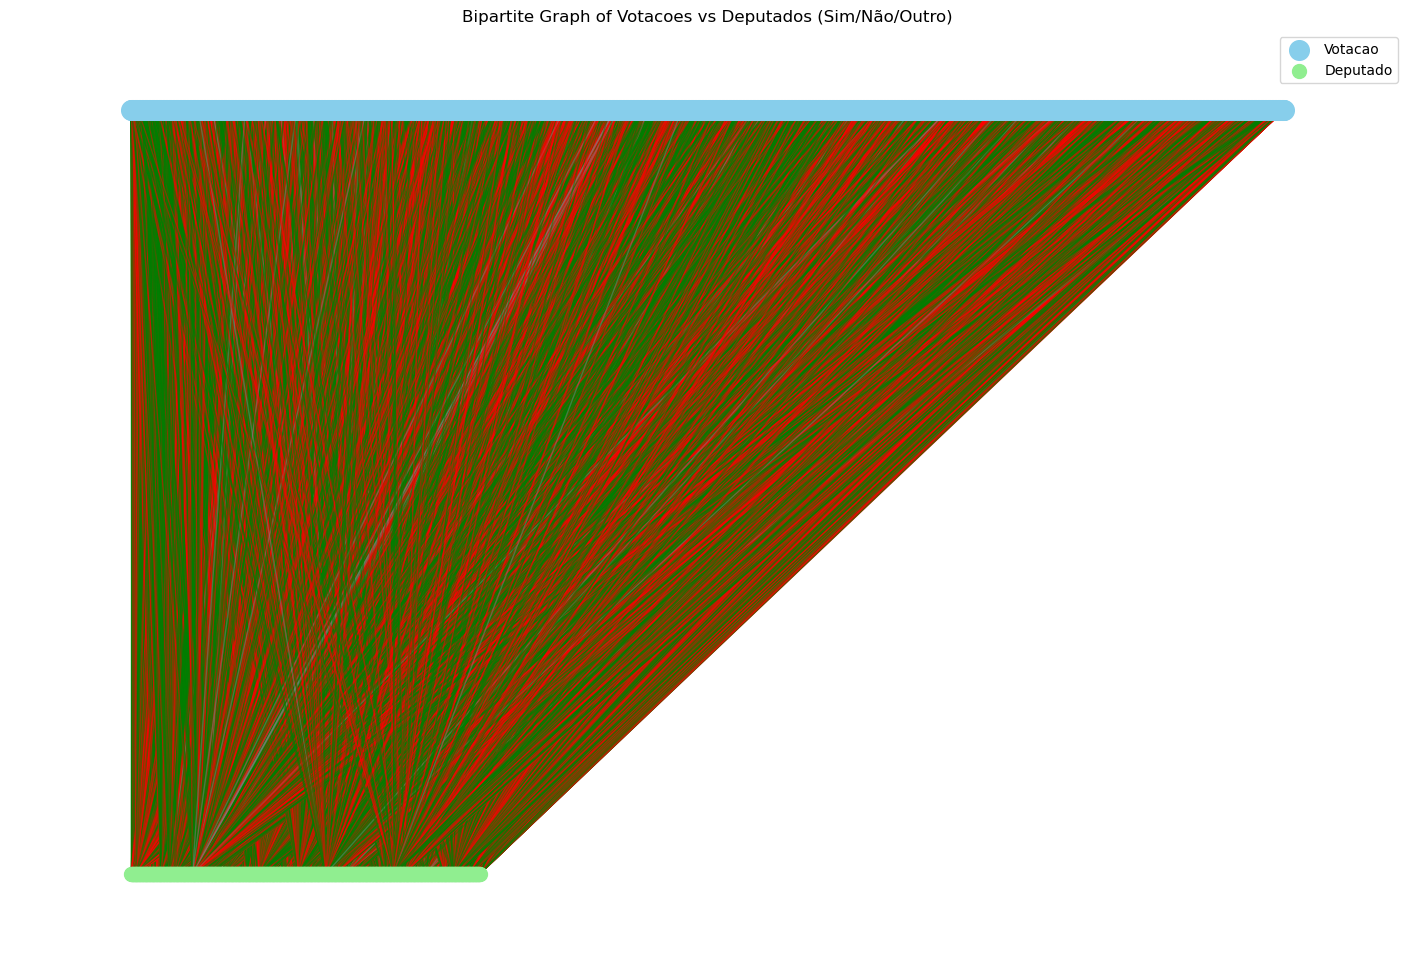

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# === 1️⃣ Load the graph ===
G = nx.read_graphml("votacoes_bipartite_colorida_acima_250.graphml")

# Separate the two node sets by the 'bipartite' attribute
votacao_nodes = {n for n, d in G.nodes(data=True) if int(d.get("bipartite", 0)) == 0}
deputado_nodes = set(G) - votacao_nodes

# === 2️⃣ Compute positions for bipartite layout ===
pos = dict()
# Votacoes on the top
pos.update((n, (i, 1)) for i, n in enumerate(votacao_nodes))
# Deputados on the bottom
pos.update((n, (i, 0)) for i, n in enumerate(deputado_nodes))

# === 3️⃣ Draw the nodes ===
plt.figure(figsize=(18, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=votacao_nodes, node_color='skyblue', node_size=100, label='Votacao')
nx.draw_networkx_nodes(G, pos, nodelist=deputado_nodes, node_color='lightgreen', node_size=100, label='Deputado')

# Draw edges with colors by 'voto'
edge_colors = []
for u, v, d in G.edges(data=True):
    voto = d.get("voto", "outro")
    if voto == "sim":
        edge_colors.append("green")
    elif voto == "não":
        edge_colors.append("red")
    else:
        edge_colors.append("gray")

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.5)

# Optional: labels for smaller graphs
# nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis('off')
plt.legend(scatterpoints=1)
plt.title("Grafo Bipartido: Deputados x Votações", fontsize=16)
plt.show()


Grafo original: 2568 nós, 790525 arestas
Grafo reduzido: 127 nós, 1951 arestas


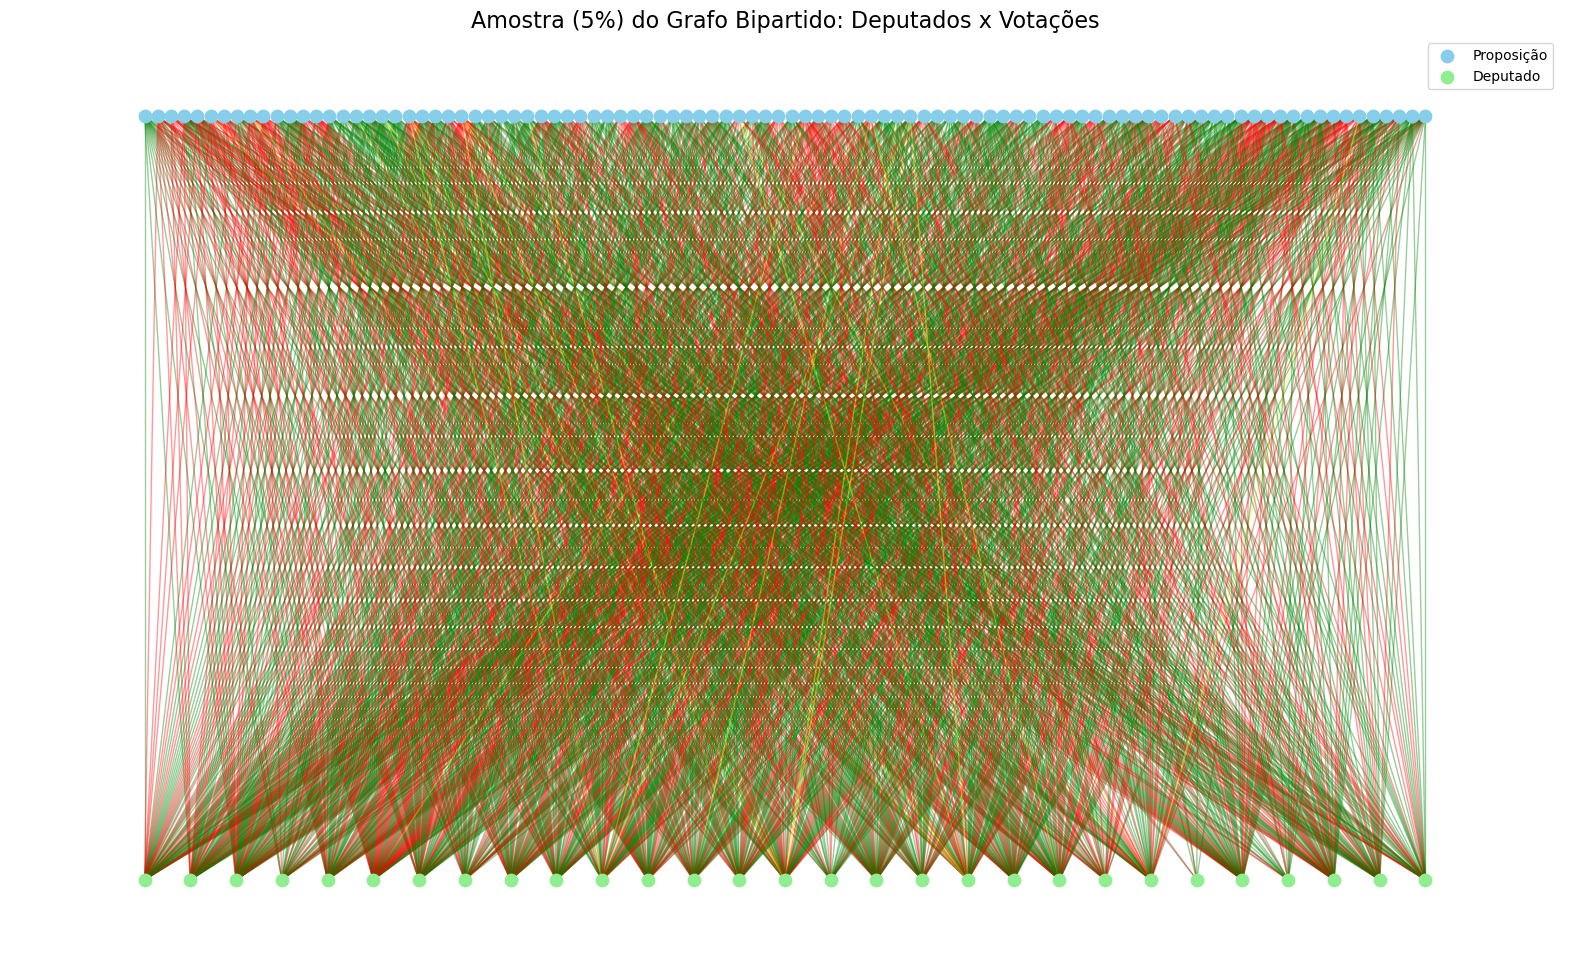

In [ ]:
# === 1️⃣ Carrega o grafo ===
G = nx.read_graphml("votacoes_bipartite_colorida_acima_250.graphml")

# === 2️⃣ Separa os conjuntos bipartidos ===
votacao_nodes = [n for n, d in G.nodes(data=True) if int(d.get("bipartite", 0)) == 0]
deputado_nodes = [n for n in G if n not in votacao_nodes]

# === 3️⃣ Seleciona 5% de cada conjunto ===
sample_frac = 0.05
num_votacoes_sample = max(1, int(len(votacao_nodes) * sample_frac))
num_deputados_sample = max(1, int(len(deputado_nodes) * sample_frac))

sample_votacoes = random.sample(votacao_nodes, num_votacoes_sample)
sample_deputados = random.sample(deputado_nodes, num_deputados_sample)

# === 4️⃣ Cria subgrafo apenas com os nós selecionados e suas arestas ===
sub_nodes = set(sample_votacoes + sample_deputados)
G_sub = G.subgraph(sub_nodes).copy()

print(f"Grafo original: {len(G)} nós, {len(G.edges())} arestas")
print(f"Grafo reduzido: {len(G_sub)} nós, {len(G_sub.edges())} arestas")

# === 5️⃣ Calcula posições com espaçamento proporcional ===
votacao_nodes_sub = [n for n in G_sub if n in sample_votacoes]
deputado_nodes_sub = [n for n in G_sub if n in sample_deputados]

num_votacoes = len(votacao_nodes_sub)
num_deputados = len(deputado_nodes_sub)

votacao_x = np.linspace(0, num_votacoes, num_votacoes)
deputado_x = np.linspace(0, num_votacoes, num_deputados)

pos = dict()
pos.update({n: (x, 1) for n, x in zip(votacao_nodes_sub, votacao_x)})
pos.update({n: (x, 0) for n, x in zip(deputado_nodes_sub, deputado_x)})

# === 6️⃣ Define cores das arestas por voto ===
edge_colors = []
for u, v, d in G_sub.edges(data=True):
    voto = d.get("voto", "outro")
    if voto == "sim":
        edge_colors.append("green")
    elif voto == "não":
        edge_colors.append("red")
    else:
        edge_colors.append("yellow")

# === 7️⃣ Desenha e salva ===
plt.figure(figsize=(20, 12))

nx.draw_networkx_nodes(G_sub, pos, nodelist=votacao_nodes_sub, node_color='skyblue', node_size=80, label='Proposição')
nx.draw_networkx_nodes(G_sub, pos, nodelist=deputado_nodes_sub, node_color='lightgreen', node_size=80, label='Deputado')
nx.draw_networkx_edges(G_sub, pos, edge_color=edge_colors, alpha=0.4)

plt.axis('off')
plt.legend(scatterpoints=1)
plt.title("Amostra (5%) do Grafo Bipartido: Deputados x Votações", fontsize=16)

plt.savefig("grafo_bipartido_amostra_5.pdf")
plt.show()


# Detecção de Comunidades

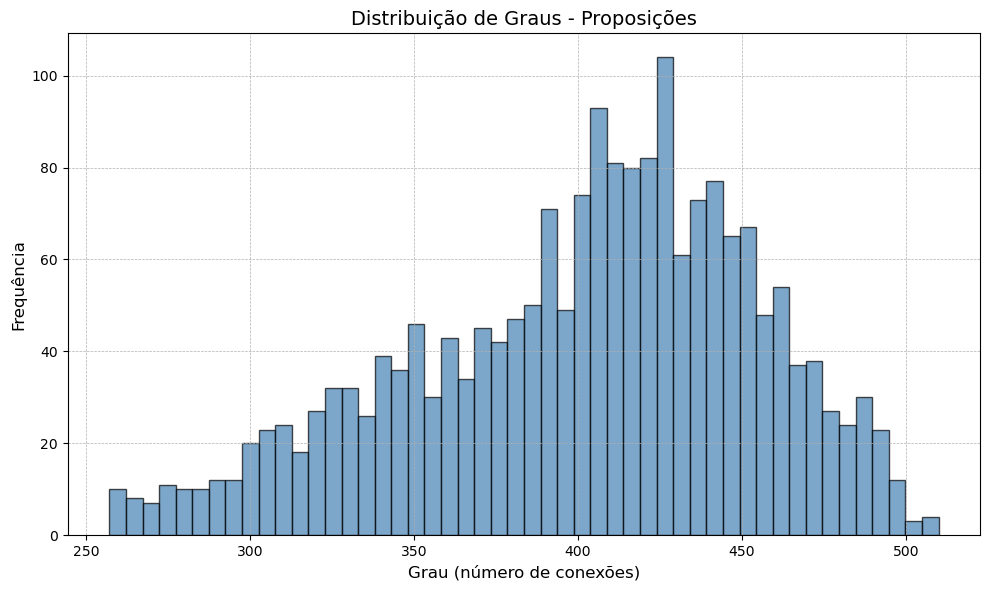

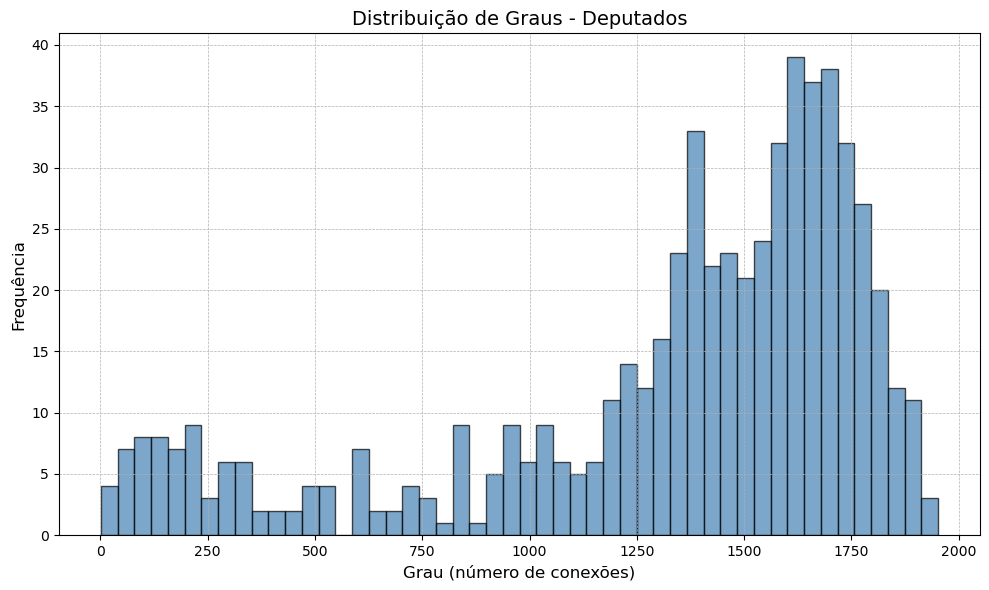

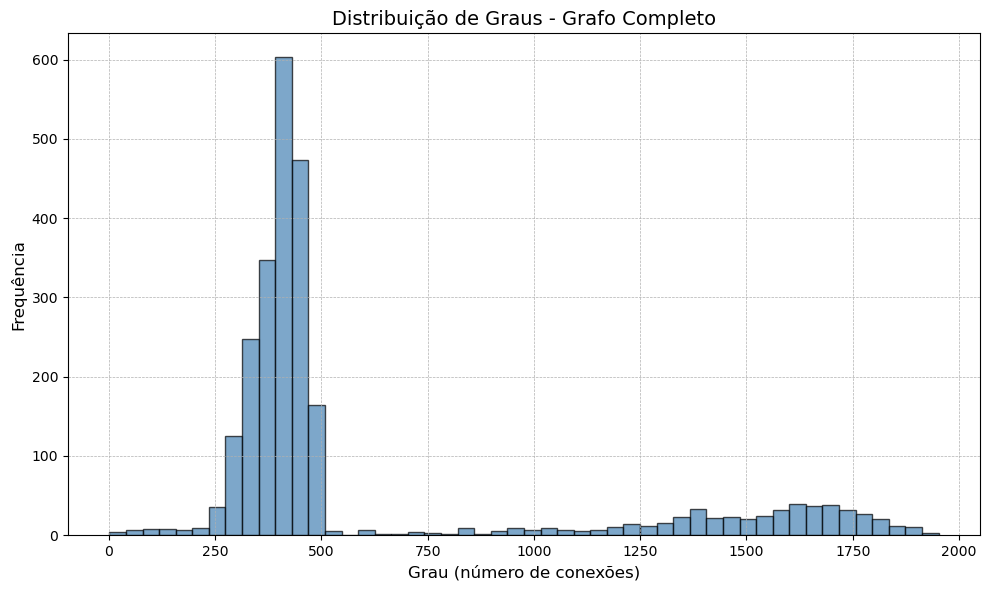

In [ ]:
# === 8️⃣ Distribuição de graus (completa e bipartida) ===
import matplotlib.pyplot as plt
import numpy as np

# --- Calcula os graus ---
graus_votacoes = [G.degree(n) for n in votacao_nodes]
graus_deputados = [G.degree(n) for n in deputado_nodes]
graus_completo = [G.degree(n) for n in G.nodes()]

# --- Função auxiliar para histogramas ---
def plot_degree_histogram(data, title, filename):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Grau (número de conexões)', fontsize=12)
    plt.ylabel('Frequência', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, ls="--", lw=0.5)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# --- Função auxiliar para log-log em pontos ---
def plot_loglog_points(data, title, filename, color='darkred'):
    values, counts = np.unique(data, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.scatter(values, counts, s=30, color=color, alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Grau (log)', fontsize=12)
    plt.ylabel('Frequência (log)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# === 9️⃣ Histogramas normais ===
plot_degree_histogram(graus_votacoes, 
                      "Distribuição de Graus - Proposições", 
                      "grau_votacoes.pdf")

plot_degree_histogram(graus_deputados, 
                      "Distribuição de Graus - Deputados", 
                      "grau_deputados.pdf")

plot_degree_histogram(graus_completo, 
                      "Distribuição de Graus - Grafo Completo", 
                      "grau_completo.pdf")

# === 🔟 Gráficos log-log em pontos ===
plot_loglog_points(graus_votacoes, 
                   "Distribuição de Graus (log-log) - Proposições", 
                   "grau_votacoes_loglog.pdf",
                   color='tab:blue')

plot_loglog_points(graus_deputados, 
                   "Distribuição de Graus (log-log) - Deputados", 
                   "grau_deputados_loglog.pdf",
                   color='tab:green')

plot_loglog_points(graus_completo, 
                   "Distribuição de Graus (log-log) - Grafo Completo", 
                   "grau_completo_loglog.pdf",
                   color='tab:orange')
